In [1]:
import numpy as np
import torch 
import sys
sys.path.append("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/")

# import swa
import torch.nn.functional as F
import torchvision
import data
import models
import utils
import tabulate
import swag
import losses

import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
model_cfg = getattr(models, "VGG16")
loaders, num_classes = data.loaders(
    "CIFAR100",
    "/home/izmailovpavel/datasets/",
    128,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None
)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [3]:
swag_model = swag.SWAG(model_cfg.base, no_cov_mat=True, max_num_models=20, *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)

In [4]:
ckpt = torch.load("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/ckpts/c100/vgg16/swag/run1/swag-300.pt")
swag_model.load_state_dict(ckpt['state_dict'])
swag_model.cuda();

In [5]:
for i, (input, target) in enumerate(loaders["test"]):
    input = input.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)
    break

In [57]:
# scales = [0.01, 0.1, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 5.]
scales = [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.]
results = []
for scale in scales:
    sum_preds = np.zeros((len(loaders["test"].dataset), 100))
    num_models = 50
    for i in range(num_models):
        swag_model.sample(scale)
        swag_model.eval()
        preds, ys = utils.predictions(loaders["test"], swag_model)
        sum_preds += preds
        print(i, ":", np.mean(np.argmax(sum_preds, axis=1) == ys), "; ", end="")
    sum_preds /= num_models
    res = np.mean(np.argmax(sum_preds, axis=1) == ys)
    print(scale, ":", res)
    results.append(res)

0 : 0.7146 ; 1 : 0.7285 ; 2 : 0.7334 ; 3 : 0.7405 ; 4 : 0.7412 ; 5 : 0.743 ; 6 : 0.7446 ; 7 : 0.7453 ; 8 : 0.7442 ; 9 : 0.7461 ; 10 : 0.747 ; 11 : 0.7474 ; 12 : 0.7478 ; 13 : 0.7476 ; 14 : 0.7488 ; 15 : 0.7497 ; 16 : 0.7501 ; 17 : 0.7503 ; 18 : 0.7501 ; 19 : 0.7491 ; 20 : 0.7483 ; 21 : 0.7487 ; 22 : 0.7479 ; 23 : 0.7498 ; 24 : 0.7494 ; 25 : 0.748 ; 26 : 0.7486 ; 27 : 0.7485 ; 28 : 0.7484 ; 29 : 0.7486 ; 30 : 0.7484 ; 31 : 0.749 ; 32 : 0.7498 ; 33 : 0.75 ; 34 : 0.7497 ; 35 : 0.7498 ; 36 : 0.749 ; 37 : 0.7492 ; 38 : 0.7498 ; 39 : 0.7496 ; 40 : 0.7496 ; 41 : 0.7495 ; 42 : 0.7495 ; 43 : 0.7489 ; 44 : 0.7496 ; 45 : 0.7497 ; 46 : 0.7497 ; 47 : 0.7499 ; 48 : 0.7503 ; 49 : 0.7501 ; 1.3 : 0.7501
0 : 0.7049 ; 1 : 0.7272 ; 2 : 0.7312 ; 3 : 0.7376 ; 4 : 0.7395 ; 5 : 0.7404 ; 6 : 0.7428 ; 7 : 0.7432 ; 8 : 0.7446 ; 9 : 0.7467 ; 10 : 0.7478 ; 11 : 0.7452 ; 12 : 0.7457 ; 13 : 0.7458 ; 14 : 0.7466 ; 15 : 0.7464 ; 16 : 0.7467 ; 17 : 0.7474 ; 18 : 0.7483 ; 19 : 0.7476 ; 20 : 0.7482 ; 21 : 0.7465 ; 22 : 0

In [58]:
for s, r in zip(scales, results):
    print(("- %.2f -> %.2f" % (s, 100*r)) + "%")

- 1.30 -> 75.01%
- 1.40 -> 74.77%
- 1.50 -> 74.90%
- 1.60 -> 74.59%
- 1.70 -> 74.73%
- 1.80 -> 74.64%
- 1.90 -> 74.67%
- 2.00 -> 74.58%


## Sanity Check from Timur

In [62]:
model = swag.SWAG(model_cfg.base, no_cov_mat=True, max_num_models=20, *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
# model2 = swag.SWAG(model_cfg.base, no_cov_mat=True, max_num_models=20, *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)

ckpt = torch.load("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/ckpts/c100/vgg16/swag/run1/swag-300.pt")
model.load_state_dict(ckpt['state_dict'])
model.cuda();

$Var = E x^2 - (E x) \Rightarrow E x^2 = (E x)^2 + Var$ 

In [63]:
def resample_weights_ball(model1, std=0.001):
    for module, name in model1.params:
        mean = module.__getattr__('%s_mean' % name)
        module.__getattr__('%s_sq_mean' % name).copy_(mean**2 + std**2)
        
def resample_weights_2(model1, c=0.1):
    for module, name in model1.params:
        mean = module.__getattr__('%s_mean' % name)
        module.__getattr__('%s_sq_mean' % name).copy_(mean**2 * (1 + c))

In [64]:
stds = [0.01]#,0.005, 0.007, 0.01, 0.012, 0.015, 0.02, 0.03, 0.04]
results = []
for std in stds:
    resample_weights_ball(model, std=std)
    sum_preds = np.zeros((len(loaders["test"].dataset), 100))
    num_models = 50
    for i in range(num_models):
        model.sample(1.)
        model.eval()
        preds, ys = utils.predictions(loaders["test"], model)
        sum_preds += preds
        print(i, ":", np.mean(np.argmax(sum_preds, axis=1) == ys), "; ", end="")
    sum_preds /= num_models
    res = np.mean(np.argmax(sum_preds, axis=1) == ys)
    print(std, ":", res)
    results.append(res)

0 : 0.7284 ; 1 : 0.7388 ; 2 : 0.7416 ; 3 : 0.7439 ; 4 : 0.744 ; 5 : 0.7456 ; 6 : 0.7456 ; 7 : 0.7471 ; 8 : 0.7468 ; 9 : 0.7468 ; 10 : 0.7473 ; 11 : 0.7461 ; 12 : 0.7466 ; 13 : 0.747 ; 14 : 0.7471 ; 15 : 0.7468 ; 16 : 0.7465 ; 17 : 0.7474 ; 18 : 0.7482 ; 19 : 0.7483 ; 20 : 0.7482 ; 21 : 0.749 ; 22 : 0.7483 ; 23 : 0.7478 ; 24 : 0.7475 ; 25 : 0.7475 ; 26 : 0.7481 ; 27 : 0.7473 ; 28 : 0.7479 ; 29 : 0.7482 ; 30 : 0.7486 ; 31 : 0.7484 ; 32 : 0.7491 ; 33 : 0.7486 ; 34 : 0.748 ; 35 : 0.7476 ; 36 : 0.7478 ; 37 : 0.7483 ; 38 : 0.7486 ; 39 : 0.7489 ; 40 : 0.7485 ; 41 : 0.7483 ; 42 : 0.7482 ; 43 : 0.7482 ; 44 : 0.7483 ; 45 : 0.7481 ; 46 : 0.7484 ; 47 : 0.7482 ; 48 : 0.748 ; 49 : 0.7476 ; 0.01 : 0.7476


In [153]:
results

[0.7456, 0.7447, 0.749, 0.7476, 0.7454, 0.7243, 0.2541, 0.019]

In [152]:
stds

[0.005, 0.007, 0.01, 0.012, 0.015, 0.02, 0.03, 0.04]

In [156]:
print("std -> ens acc")
for s, r in zip(stds, results):
    print(("- %.3f -> %.2f" % (s, 100*r)) + "%")

std -> ens acc
- 0.005 -> 74.56%
- 0.007 -> 74.47%
- 0.010 -> 74.90%
- 0.012 -> 74.76%
- 0.015 -> 74.54%
- 0.020 -> 72.43%
- 0.030 -> 25.41%
- 0.040 -> 1.90%


In [159]:
cs = [0.0075, 0.01, 0.0125]
results = []
for c in cs:
    resample_weights_2(model, c=c)
    sum_preds = np.zeros((len(loaders["test"].dataset), 100))
    num_models = 50
    for i in range(num_models):
        model.sample(1.)
        model.eval()
        preds, ys = utils.predictions(loaders["test"], model)
        sum_preds += preds
        print(i, ":", np.mean(np.argmax(sum_preds, axis=1) == ys), "; ", end="")
    sum_preds /= num_models
    res = np.mean(np.argmax(sum_preds, axis=1) == ys)
    print(c, ":", res)
    results.append(res)

0 : 0.7399 ; 1 : 0.7431 ; 2 : 0.7434 ; 3 : 0.7435 ; 4 : 0.7448 ; 5 : 0.746 ; 6 : 0.746 ; 7 : 0.7466 ; 8 : 0.7458 ; 9 : 0.7469 ; 10 : 0.747 ; 11 : 0.7468 ; 12 : 0.7472 ; 13 : 0.7473 ; 14 : 0.7471 ; 15 : 0.7469 ; 16 : 0.7462 ; 17 : 0.7463 ; 18 : 0.7467 ; 19 : 0.7463 ; 20 : 0.7462 ; 21 : 0.7465 ; 22 : 0.7463 ; 23 : 0.7459 ; 24 : 0.7464 ; 25 : 0.7461 ; 26 : 0.7456 ; 27 : 0.7458 ; 28 : 0.746 ; 29 : 0.7461 ; 30 : 0.7463 ; 31 : 0.7463 ; 32 : 0.746 ; 33 : 0.7459 ; 34 : 0.7455 ; 35 : 0.7455 ; 36 : 0.7454 ; 37 : 0.7453 ; 38 : 0.7455 ; 39 : 0.7456 ; 40 : 0.7454 ; 41 : 0.7456 ; 42 : 0.7452 ; 43 : 0.7453 ; 44 : 0.7455 ; 45 : 0.745 ; 46 : 0.7451 ; 47 : 0.7453 ; 48 : 0.7455 ; 49 : 0.7459 ; 0.0075 : 0.7459
0 : 0.7389 ; 1 : 0.7409 ; 2 : 0.742 ; 3 : 0.7456 ; 4 : 0.7453 ; 5 : 0.746 ; 6 : 0.7456 ; 7 : 0.7456 ; 8 : 0.7456 ; 9 : 0.746 ; 10 : 0.7466 ; 11 : 0.7468 ; 12 : 0.7468 ; 13 : 0.7463 ; 14 : 0.747 ; 15 : 0.7468 ; 16 : 0.7469 ; 17 : 0.7468 ; 18 : 0.747 ; 19 : 0.7465 ; 20 : 0.7465 ; 21 : 0.7463 ; 22 : 0.

## Are variances we get correlated with width?

In [43]:
model = swag.SWAG(model_cfg.base, no_cov_mat=True, max_num_models=20, *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
# model2 = swag.SWAG(model_cfg.base, no_cov_mat=True, max_num_models=20, *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)

ckpt = torch.load("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/ckpts/c100/vgg16/swag/run1/swag-300.pt")
model.load_state_dict(ckpt['state_dict'])
model.cuda();


In [38]:
def get_variances(model):
    variances = {}
    for module, name in model.params:
        mean = module.__getattr__('%s_mean' % name)
        sq_mean = module.__getattr__('%s_sq_mean' % name)
        var = sq_mean - mean**2
        variances[name] = (mean, var)
    return variances

In [42]:
def vary_parameter(model, module, name, idx, t):
    mean = module.__getattr__('%s_mean' % name)
    mean[idx] += t
    module.__getattr__('%s_mean' % name).copy_(mean)

In [120]:
for module, name in model.params:
    mean = module.__getattr__('%s_mean' % name)
    sq_mean = module.__getattr__('%s_sq_mean' % name)
    var = sq_mean - mean**2
    var = var.cpu().numpy()
    if np.max(var) > 1e-2:
        print("success")
        break

success


now let's fix module and name

In [121]:
def get_idx_by_var(module, name, desired_var):
    mean = module.__getattr__('%s_mean' % name)
    sq_mean = module.__getattr__('%s_sq_mean' % name)
    var = sq_mean - mean**2
    var = var.cpu().numpy()
    idx = np.unravel_index(np.argmin(np.abs(var - desired_var)), var.shape)
    return idx

In [122]:
def get_ray(model, module, name, ckpt, idx, tmin=-5, tmax=5):
    loss_vals = {}
    for t in tqdm.tqdm(np.linspace(-10, 10, 5)):
        model.load_state_dict(ckpt['state_dict'])
        vary_parameter(model, module, name, idx, t)
        model.sample(0.)
        loss = utils.eval(loaders["train"], model, losses.cross_entropy)
        loss_vals[t] = loss['loss']
    ts = np.array(list(loss_vals.keys()))
    loss_vals = np.array(list(loss_vals.values()))
    idx = np.argsort(ts)
    ts = ts[idx]
    loss_vals = loss_vals[idx]
    return loss_vals, ts

In [124]:
idx = get_idx_by_var(module, name, 1e-6)
ls_1e6, ts_1e6 = get_ray(model, module, name, ckpt, idx)

idx = get_idx_by_var(module, name, 1e-5)
ls_1e5, ts_1e5 = get_ray(model, module, name, ckpt, idx)

idx = get_idx_by_var(module, name, 1e-4)
ls_1e4, ts_1e4 = get_ray(model, module, name, ckpt, idx)

idx = get_idx_by_var(module, name, 1e-3)
ls_1e3, ts_1e3 = get_ray(model, module, name, ckpt, idx)

idx = get_idx_by_var(module, name, 1e-2)
ls_1e2, ts_1e2 = get_ray(model, module, name, ckpt, idx)

100%|██████████| 5/5 [00:24<00:00,  4.88s/it]


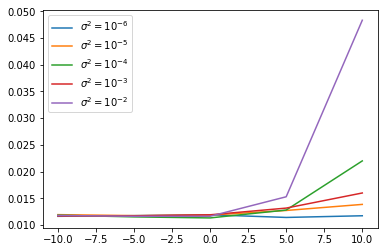

In [125]:
plt.plot(ts_1e6, ls_1e6, label=r"$\sigma^2=10^{-6}$")
plt.plot(ts_1e5, ls_1e5, label=r"$\sigma^2=10^{-5}$")
plt.plot(ts_1e4, ls_1e4, label=r"$\sigma^2=10^{-4}$")
plt.plot(ts_1e3, ls_1e3, label=r"$\sigma^2=10^{-3}$")
plt.plot(ts_1e2, ls_1e2, label=r"$\sigma^2=10^{-2}$")
plt.legend()

## Can  we try to invert the variances?

In [58]:
swag_model = swag.SWAG(model_cfg.base, no_cov_mat=True, max_num_models=20, *model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
ckpt = torch.load("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/ckpts/c100/vgg16/swag/run1/swag-300.pt")
swag_model.load_state_dict(ckpt['state_dict'])
swag_model.cuda();

In [57]:
def invert_variances(model):
    for module, name in model.params:
        mean = module.__getattr__('%s_mean' % name)
        sq_mean = module.__getattr__('%s_sq_mean' % name)
        var = sq_mean - mean**2
#         max_var = torch.max(torch.abs(var))
#         min_var = torch.min(torch.abs(var))
#         var = max_var * min_var / var
#         var = 1e-9 / var
        
        new_var = torch.zeros_like(var)
        new_var[torch.abs(var) <= 1e-3] = 1e-4#1e-4
        new_var[torch.abs(var) <= 1e-6] = 1e-3#1e-3
        new_var[torch.abs(var) > 1e-4] = 0.#1e-6
        new_var[torch.abs(var) > 1e-3] = 0.#1e-6
        new_var[torch.abs(var) > 1e-2] = 0.#1e-6
        sq_mean = mean**2 + new_var
        module.__getattr__('%s_sq_mean' % name).copy_(sq_mean)

In [59]:
# invert_variances(swag_model)

In [60]:
for module, name in swag_model.params:
    mean = module.__getattr__('%s_mean' % name)
    sq_mean = module.__getattr__('%s_sq_mean' % name)
    var = sq_mean - mean**2
    print(torch.max(var))

tensor(0.0021, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0019, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(0.0017, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(0.0016, device='cuda:0')
tensor(7.6939e-05, device='cuda:0')
tensor(0.0015, device='cuda:0')
tensor(6.5865e-05, device='cuda:0')
tensor(0.0023, device='cuda:0')
tensor(8.3825e-05, device='cuda:0')
tensor(0.0015, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(0.0013, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0010, device='cuda:0')
tensor(0.0007, device='cuda:0')
tensor(0.0003, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0016, device='cuda:0')
tensor(0.0323, device='cuda:0')
tensor(0.0005, device='cuda:0')
tensor(7.9844e-05, device='cuda:0')
tensor(0.0003, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(0.0034, device='cuda:0')
tensor(0.0007, device='c

In [61]:
scales = [1.]
results = []
for scale in scales:
    sum_preds = np.zeros((len(loaders["test"].dataset), 100))
    num_models = 50
    for i in range(num_models):
        swag_model.sample(scale)
        swag_model.eval()
        preds, ys = utils.predictions(loaders["test"], swag_model)
        sum_preds += preds
        print(i, ":", np.mean(np.argmax(sum_preds, axis=1) == ys), "; ", end="")
    sum_preds /= num_models
    res = np.mean(np.argmax(sum_preds, axis=1) == ys)
    print()
    print(scale, ":", res)
    results.append(res)

0 : 0.7264 ; 1 : 0.7392 ; 2 : 0.7434 ; 3 : 0.7433 ; 4 : 0.7447 ; 5 : 0.745 ; 6 : 0.7457 ; 7 : 0.746 ; 8 : 0.7463 ; 9 : 0.7466 ; 10 : 0.7481 ; 11 : 0.7458 ; 12 : 0.7464 ; 13 : 0.7469 ; 14 : 0.7477 ; 15 : 0.7482 ; 16 : 0.7468 ; 17 : 0.7475 ; 18 : 0.748 ; 19 : 0.7487 ; 20 : 0.7486 ; 21 : 0.7488 ; 22 : 0.7487 ; 23 : 0.7478 ; 24 : 0.7472 ; 25 : 0.7474 ; 26 : 0.7478 ; 27 : 0.7476 ; 28 : 0.7483 ; 29 : 0.7483 ; 30 : 0.7485 ; 31 : 0.7478 ; 32 : 0.7475 ; 33 : 0.7475 ; 34 : 0.7477 ; 35 : 0.7478 ; 36 : 0.7473 ; 37 : 0.7474 ; 38 : 0.7473 ; 39 : 0.7471 ; 40 : 0.7475 ; 41 : 0.747 ; 42 : 0.747 ; 43 : 0.7473 ; 44 : 0.7471 ; 45 : 0.7473 ; 46 : 0.7473 ; 47 : 0.7461 ; 48 : 0.7472 ; 49 : 0.7476 ; 
1.0 : 0.7476


## SGD-SGD rays

In [298]:
model_cfg = getattr(models, "VGG16")
loaders, num_classes = data.loaders(
    "CIFAR100",
    "/home/izmailovpavel/datasets/",
    128,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None
)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [351]:
model300 = model_cfg.base(num_classes=num_classes)
ckpt = torch.load("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/ckpts/c100/vgg16/swag/run1/checkpoint-300.pt")
model300.load_state_dict(ckpt['state_dict'])
model300.cuda();

model275 = model_cfg.base(num_classes=num_classes)
ckpt = torch.load("/home/izmailovpavel/Documents/Projects/private_swa_uncertainties/ckpts/c100/vgg16/swag/run1/checkpoint-275.pt")
model275.load_state_dict(ckpt['state_dict'])
model275.cuda();

model = model_cfg.base(num_classes=num_classes)

In [352]:
def dist(m1, m2):
    d = 0.
    for param1, param2 in zip(m1.parameters(), m2.parameters()):
        d += torch.norm(param1 - param2)**2
    return torch.sqrt(d).item()

In [353]:
dist(model275, model300)

30.30549430847168

In [369]:
def ray(model_target, model1, model2, t_min=-1., t_max=2., num_t=10.):
    loss_vals = []
    accs = []
    dists = []
    ts = np.linspace(t_min, t_max, num_t)
    for t in tqdm.tqdm(ts):
        for p1, p2, p3 in zip(model_target.parameters(), model1.parameters(), model2.parameters()):
            p1.data = p2.data * (1 - t) + p3.data * (t)
        d = dist(model_target, model1)
#         print(d)
#         print(t)
        loss = utils.eval(loaders["train"], model, losses.cross_entropy)
        loss_vals.append(loss['loss'])
        accs.append(loss['accuracy'])
        dists.append(d * np.sign(t))
#         print(dists)
#         print()
    return ts, dists, accs, loss_vals

In [370]:
ts, ds, accs, ls = ray(model, model275, model300, num_t=10)

100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


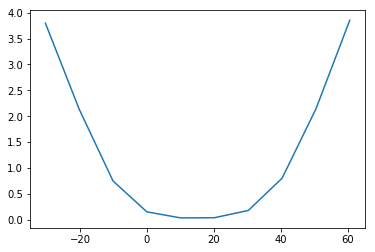

In [371]:
plt.plot(ds, ls)

In [374]:
rand_model = model_cfg.base(num_classes=num_classes)
rand_model.cuda()
norm= 0.
for p in rand_model.parameters():
    p.data = torch.randn_like(p)
    norm += torch.norm(p.data)**2
norm = torch.sqrt(norm)
for p1, p2 in zip(model275.parameters(), rand_model.parameters()):
    p2.data = p1.data + p2.data / norm

In [376]:
ts, ds, accs, ls = ray(model, model275, rand_model, t_min=-30, t_max=30, num_t=10)

100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


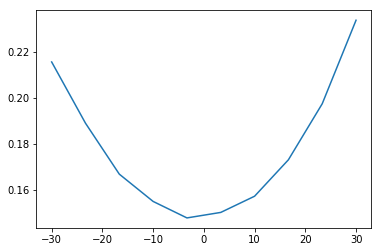

In [377]:
plt.plot(ds, ls)